Simple 2d power spectra generation (random gaussian field) with some simple analysis run on the position space results.

TODO:

-Extend to higher dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
import corner


from scipy.optimize import minimize
from scipy.special import gamma

Create a class for generating the power spectrum.  Spectra are characterized by an amplitude and power-law exponent: $\langle \phi(k)\phi(-k)\rangle'=\frac{\rm amplitude}{k^{\rm power}}$, corresponding in position space to $\langle \phi(x)\phi(0)\rangle\propto \frac{\rm amplitude}{x^{d-{\rm power}}}$ in $d$-dimensions. Grid size is $2^{\rm size\_exponent}$ and ${\rm dimensions}=2$ is the number of spatial dimensions; expansion to other dimensions to come later.

In [8]:
class cmb():

    def __init__(self, amplitude=1, power=1.75, size_exponent=3, dimensions=2):
        self.amplitude = amplitude
        self.power = power
        self.size = 2**(size_exponent)
        self.dimensions = dimensions
    
    def _theory_xspace(self,theta,x):
            amplitude,power=theta
            """
            The theoretical position space correlator, given the model parameters. Only valid for 2d right now
            """
            return 1/(np.pi*(2**power))*amplitude*x**(power-2)*gamma(1-power/2)/gamma(power/2)

    def generate(self):
        """
        generating the spectrum
        """
        # creating a grid w/ each point pulled from std normal
        gaussianseed = np.random.normal(
            size=[self.size for _ in range(self.dimensions)])
        # fourier transform
        gaussianseedfourier = np.fft.fft2(gaussianseed)
        # numpy's fft algorithm automatically indexes with negative values on right half
        # positive on left half, as desired

        # relevant momenta vectors with desired fft indexing
        kvector = [(2*np.pi/self.size)*i for i in range(int(self.size/2+1))] + \
            [(2*np.pi/self.size)*i for i in range(int(-self.size/2+1), 0)]
        
        # power spectrum function
        def powerspectrum(i, j):
        # regulating the k=0 divergence:
            if i == j == 0:
                return 0
            else:
                ktotal = np.sqrt(kvector[i]**2+kvector[j]**2)
                return self.amplitude*(ktotal**(-self.power))
        
        # create grid of relevant (square-root of) power spectrum values
        powergridsqrt = np.array([[np.sqrt(powerspectrum(i, j))
                                   for i in range(self.size)] for j in range(self.size)])
        
        # multiply by the transformed white noise
        gaussianseedfourierwithspectra = gaussianseedfourier*powergridsqrt
        
        # transform back and take the real part to get the spectrum
        self.spectrum = np.real(np.fft.ifft2(gaussianseedfourierwithspectra))       
        
        # imaginary parts are from numerical errors; they're very small
        imToReRatio=np.imag(np.fft.ifft2(gaussianseedfourierwithspectra))/np.real(np.fft.ifft2(gaussianseedfourierwithspectra))
        print('Sanity check: ratio of imaginary to real components in generated data:')
        print('Average ratio:', np.mean(imToReRatio),'Standard dev.:',np.std(imToReRatio))

    def spectrumplot(self):
        """
        plotting the spectrum
        """
        if hasattr(self, 'spectrum'):
            _, ax = plt.subplots()
            ax.imshow(self.spectrum)
            plt.show()
        else:
            print('Run generate to create spectrum first')

    def hist(self):
        """
        histogram of generated values
        """

        if not hasattr(self, 'spectrum'):
            return print('Run generate to create spectrum first')

        data = self.spectrum.flatten()
        std = np.std(data)
        self.std = std
        # plot data
        _, ax = plt.subplots()
        ax.hist(data, bins=100, density=True)
        ax.set_xlabel(f'$\sigma$={std:.5f}')
        ax.set_ylabel('$\phi$')
        ax.set_title('Distribution of generated points')
        # plot fit
        x = np.linspace(-5*std, 5*std, 100)
        y = stats.norm.pdf(x, 0, std)
        ax.plot(x, y)
        plt.show()
        plt.close()

    def bin_pair_data(self, maxlen=None):
        """
        Collect all independent pairs of data points separated by less than maxlen
        and bin them by distance, rounding to nearest integer.  
        
        getting the various relevant data points from the position-space spectrum
        data points are tuples containing an array with the two signals
        and two more arrays with their locations
        maxlen throws out all data points whose distance is larger than maxlen
        (bottleneck, should improve)
        """
        # dynamically choosing maxlen:
        # (should probably be adding 1 to maxlen everywhere due to how we later round for binning)
        if maxlen == None:
            maxlen = int(self.size//10)
        data = []
        for i in range(maxlen, self.size):
            for j in range(maxlen, self.size):
                for a in range(max(i-maxlen, 0), i):
                    for b in range(max(j-maxlen, 0), j):
                        if (i-a)**2+(j-b)**2 < maxlen**2:
                            data.append((np.array([self.spectrum[i][j], self.spectrum[a][b]]), np.array(
                                [i, j]), np.array([a, b])))

        print('Independent data pairs analyzed:', len(data))
        self.pair_data = data

    def bin_and_plot(self):
        """
        bin data by distances, then plot against simple regression fit and the known exact result
        """
        if not hasattr(self, 'pair_data'):
            return print('Run bin_pair_data first')

        if not hasattr(self, 'binned_pair_data'):
            def dist(p1, p2):
                return np.sqrt(np.dot(p1-p2, p1-p2))
            # create dictionary whose keys are the distance between points, rounded down
            datadict = {}
            for d in self.pair_data:
                d_dist = int(round(dist(d[1], d[2])))
                if d_dist not in datadict:
                    datadict[d_dist] = [np.prod(d[0])]
                else:
                    datadict[d_dist].append(np.prod(d[0]))
            self.binned_pair_data = datadict

        # plot all data points first:
        _, ax = plt.subplots()

        # then create means of data points
        # data points
        binnedxpoints = [key for key in self.binned_pair_data]
        meanbinnedydata = [np.mean(self.binned_pair_data[key])
                           for key in self.binned_pair_data]
        # standard deviation on y measurements
        meanbinnedystds = [np.std(self.binned_pair_data[key])/np.sqrt(len(self.binned_pair_data[key]))
                           for key in self.binned_pair_data]
        


        ax.errorbar(binnedxpoints, meanbinnedydata,yerr=meanbinnedystds, marker='^', color='k')

        # perform simple lin-reg analysis on binned data
        # for scaling ansatz that P(x)=A*x^B
        lrx = np.array([[1, np.log(value)] for value in binnedxpoints])
        # take abs of the values, just to prevent ln errors
        # should only affect some end points and this is a rough analysis anyway
        lry = np.array([np.log(np.abs(value)) for value in meanbinnedydata])
        lry = lry.reshape([-1, 1])
        xxmatrix = lrx.T.dot(lrx)
        xxinv = np.linalg.inv(xxmatrix)
        betafit = xxinv.dot(lrx.T).dot(lry)
        # so, the predicted function is
        def ypredictfn(x):
            return np.exp(betafit[0])*(x**(betafit[1]))

        xpredictions = np.linspace(
            binnedxpoints[0], binnedxpoints[-1], num=100)
        ypredictions = ypredictfn(xpredictions)
        ax.plot(xpredictions, ypredictions, linestyle='-', color='r',label='least-squares')

        # the analytic result from spectrum parameters is:
    
        
        yanalyticpoints = self._theory_xspace((self.amplitude,self.power),xpredictions)
        ax.plot(xpredictions, yanalyticpoints, linestyle=':', color='m',label='theory')

        # labelling and legends
        xpower = betafit[1][0]
        kpower = -xpower-self.dimensions
        ax.set_title(
            f'$yfit\\approx  {np.exp(betafit[0][0]):2f} \\cdot x^{{{xpower:2f}}}\\longleftrightarrow Pfit(k)\\sim k^{{{kpower:2f}}} $')

        ax.set_xlabel(
            f'$ytheory\\approx  {1/(np.pi*(2**self.power))*self.amplitude*gamma(1-self.power/2)/gamma(self.power/2):2f} \\cdot x^{{{self.power-2:2f}}} \\longleftrightarrow Ptheory(k)= {self.amplitude} \\cdot k^{{{-self.power:2f}}} $')
        ax.legend()

        plt.show()
        plt.close()

        # save fits and binned summary data
        self.lr_fits = {'amplitude': np.exp(betafit[0][0]),
                        'xpower': betafit[1][0]}
        self.binned_data=np.array([binnedxpoints,meanbinnedydata,meanbinnedystds])

    

    def bayes(self, amplitude_max=10,
                     power_max=2,
                     nsteps=10**4,
                     walkers=32):
        """
        bayesian analysis for power-spectrum parameters
        using binned data
        """

        if not hasattr(self, 'binned_data'):
            return print('Run bin_and_plot first')


        # set flat priors on the amplitude and power over following range
        amp_max,power_max=5*self.amplitude,1.9

        def log_prior(theta):
            amplitude, power = theta
            if 0 < amplitude < amp_max and 0 < power < power_max:
                return 0.0
            return -np.inf

        def log_likelihood(theta,data):
            x,y,sigy=data
            return np.sum(-np.log(sigy)-.5*(self._theory_xspace(theta,x)-y)**2/sigy**2)


        # total log-prob needed for MCMC
        def log_posterior(theta, data):
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp+log_likelihood(theta, data)

        

        # run MCMC with walkers starting at random points in the prior range
        pos = np.concatenate((np.random.uniform(0,amp_max, (walkers,1)),
                              np.random.uniform(0,power_max, (walkers,1))), axis=1)
        nwalkers, ndim = pos.shape
        
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_posterior, args=[self.binned_data])
        sampler.run_mcmc(pos, nsteps, progress=True)
        samples = sampler.get_chain()
        
        
        
        # plotting chain convergence
        fig, axs=plt.subplots(2)
        for i in range(nwalkers):
            for j in range(ndim):
                axs[j].plot(samples[:,i,j])

        axs[0].set_ylabel('amp')
        axs[1].set_ylabel('power')
        fig.suptitle('Chain convergence')
        plt.show()
        plt.close()

        # burn 1/4 of data, then make corner plots
        flat_samples=sampler.get_chain(discard=int(nsteps//4),thin=1,flat=True)
        amp_samples, power_samples=flat_samples[:,0],flat_samples[:,1]

        fig = corner.corner(flat_samples, levels=[0.68,0.95,0.99], 
                    labels=['amp', 'power'], quantiles=[0.16,0.5,0.84],truths=[self.amplitude,self.power],truth_color='r')

        plt.show()

Then run a realization and analyze.  Choose the amplitude and power randomly from some range

amplitude: 2.5137817345266966 
power: 0.9412523226314291
Sanity check: ratio of imaginary to real components in data:
Average ratio: -5.416095935447705e-17 Standard dev.: 6.849171074404865e-15


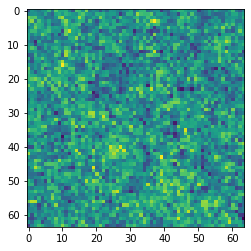

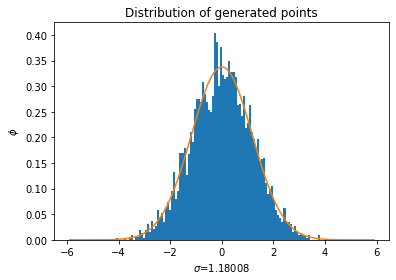

Independent data pairs analyzed: 195372


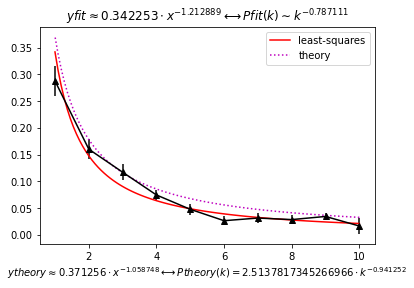

100%|██████████| 5000/5000 [00:07<00:00, 631.29it/s]


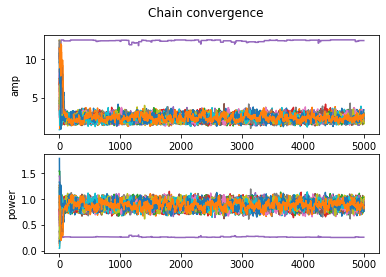

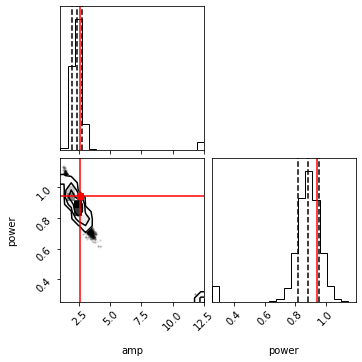

In [9]:

rand_amp,rand_power=np.random.uniform(0,10,1)[0],np.random.uniform(.2,1.5,1)[0]
print('amplitude:',rand_amp,'\npower:',rand_power)

c = cmb(size_exponent=6, amplitude=rand_amp, power=rand_power)
c.generate()
c.spectrumplot()
c.hist()
c.bin_pair_data(maxlen=10)
c.bin_and_plot()
c.bayes(nsteps=5*10**3,walkers=32)